In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import glob
from PIL import Image

In [2]:
import json
from pandas import json_normalize
with open('../input/weathertime-classification-with-road-images/train_dataset/train.json') as f:
    data = f.read()
dict = json.loads(data)
train_ds = json_normalize(dict['annotations']) 
train_ds.head(10)

,filename,period,weather
0,train_images\00001.jpg,Morning,Cloudy
1,train_images\00002.jpg,Afternoon,Cloudy
2,train_images\00003.jpg,Morning,Cloudy
3,train_images\00004.jpg,Morning,Sunny
4,train_images\00005.jpg,Afternoon,Cloudy
5,train_images\00006.jpg,Afternoon,Cloudy
6,train_images\00007.jpg,Dawn,Cloudy
7,train_images\00009.jpg,Afternoon,Cloudy
8,train_images\00010.jpg,Morning,Cloudy
9,train_images\00011.jpg,Morning,Rainy


In [3]:
weather_list=train_ds.weather.unique()
period_list=train_ds.period.unique()
print(weather_list)
print(period_list)

['Cloudy' 'Sunny' 'Rainy']
['Morning' 'Afternoon' 'Dawn' 'Dusk']


In [4]:
import matplotlib.image as mpimg
import os
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images



In [5]:
train_ds['filename'] = train_ds['filename'].str.replace('\\', '/', regex=True)
for i in range (train_ds.shape[0]) :
    train_ds['filename'].iloc[i]= '../input/weathertime-classification-with-road-images/train_dataset/' +train_ds['filename'].iloc[i]

print(train_ds['period'].value_counts())
print(train_ds['weather'].value_counts())
train_ds.filename.iloc[1] 
train_ds.head()

Morning      1613
Afternoon     829
Dusk          124
Dawn           34
Name: period, dtype: int64
Cloudy    1119
Sunny      886
Rainy      595
Name: weather, dtype: int64


,filename,period,weather
0,../input/weathertime-classification-with-road-...,Morning,Cloudy
1,../input/weathertime-classification-with-road-...,Afternoon,Cloudy
2,../input/weathertime-classification-with-road-...,Morning,Cloudy
3,../input/weathertime-classification-with-road-...,Morning,Sunny
4,../input/weathertime-classification-with-road-...,Afternoon,Cloudy


In [6]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=True,
    rotation_range=2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    channel_shift_range=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    
    # PARAMS TO EXPLORE
    validation_split=0.2,
    zoom_range=0.1,
    preprocessing_function=None
)

In [7]:
train_weather=train_ds.drop('period', axis=1)
train_period=train_ds.drop('weather',axis=1)


In [8]:
train_weather.head()

,filename,weather
0,../input/weathertime-classification-with-road-...,Cloudy
1,../input/weathertime-classification-with-road-...,Cloudy
2,../input/weathertime-classification-with-road-...,Cloudy
3,../input/weathertime-classification-with-road-...,Sunny
4,../input/weathertime-classification-with-road-...,Cloudy


In [9]:
train_period.head()

,filename,period
0,../input/weathertime-classification-with-road-...,Morning
1,../input/weathertime-classification-with-road-...,Afternoon
2,../input/weathertime-classification-with-road-...,Morning
3,../input/weathertime-classification-with-road-...,Morning
4,../input/weathertime-classification-with-road-...,Afternoon


In [10]:
mytrain=datagen.flow_from_dataframe(
    train_weather,
    x_col='filename',
    y_col='weather',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True, 
    subset="training"
)
myvalid=datagen.flow_from_dataframe(
    train_weather,
    x_col='filename',
    y_col='weather',
    target_size=(224,224),
    color_mode='rgb',
     class_mode='categorical',
    batch_size=32,
    shuffle=True, 
    subset="validation"
)

Found 2080 validated image filenames belonging to 3 classes.
Found 520 validated image filenames belonging to 3 classes.


In [11]:
mytrain2=datagen.flow_from_dataframe(
    train_period,
    x_col='filename',
    y_col='period',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True, 
    subset="training"
)
myvalid2=datagen.flow_from_dataframe(
    train_period,
    x_col='filename',
    y_col='period',
    target_size=(224,224),
    color_mode='rgb',
     class_mode='categorical',
    batch_size=32,
    shuffle=True, 
    subset="validation"
)

Found 2080 validated image filenames belonging to 4 classes.
Found 520 validated image filenames belonging to 4 classes.


In [12]:

base_model=tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=3,  
)

2022-09-27 18:56:15.106288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 18:56:15.116447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 18:56:15.117472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 18:56:15.118985: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:

base_model2=tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None,
    classes=4,
    
)


In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [15]:
base_model2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
base_model.trainable = False#freezing
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = Dense(3,activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [17]:
base_model2.trainable = False#freezing
inputs2 = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False 
x2 = base_model2(inputs2, training=False)
x2 = keras.layers.GlobalAveragePooling2D()(x2)
# A Dense classifier with a single unit (binary classification)
outputs2 = Dense(4,activation='softmax')(x2)
model2 = keras.Model(inputs2, outputs2)

In [18]:
model.compile(loss ='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
model2.compile(loss ='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [20]:
my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]

In [21]:
m1 = model.fit(
    mytrain,
    validation_data=myvalid,
    epochs=20,
    callbacks=my_callbacks,
    verbose=1
)

2022-09-27 18:57:04.344124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-09-27 18:57:09.200311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


65/65 [==============================] - 110s 2s/step - loss: 0.8320 - accuracy: 0.6375 - val_loss: 0.5685 - val_accuracy: 0.8250
Epoch 2/20
65/65 [==============================] - 88s 1s/step - loss: 0.5376 - accuracy: 0.8115 - val_loss: 0.5097 - val_accuracy: 0.8269
Epoch 3/20
65/65 [==============================] - 88s 1s/step - loss: 0.4448 - accuracy: 0.8404 - val_loss: 0.4213 - val_accuracy: 0.8596
Epoch 4/20
65/65 [==============================] - 89s 1s/step - loss: 0.3894 - accuracy: 0.8678 - val_loss: 0.4965 - val_accuracy: 0.8442
Epoch 5/20
65/65 [==============================] - 88s 1s/step - loss: 0.3420 - accuracy: 0.8909 - val_loss: 0.4287 - val_accuracy: 0.8558
Epoch 6/20
65/65 [==============================] - 88s 1s/step - loss: 0.3158 - accuracy: 0.8962 - val_loss: 0.3327 - val_accuracy: 0.9000
Epoch 7/20
65/65 [==============================] - 88s 1s/step - loss: 0.3000 - accuracy: 0.9048 - val_loss: 0.2817 - val_accuracy: 0.9058
Epoch 8/20
65/65 [============

In [22]:
m2 = model2.fit(
    mytrain2,
    validation_data=myvalid2,
    epochs=10,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/10
65/65 [==============================] - 92s 1s/step - loss: 0.8795 - accuracy: 0.6375 - val_loss: 0.7197 - val_accuracy: 0.7654
Epoch 2/10
65/65 [==============================] - 88s 1s/step - loss: 0.6175 - accuracy: 0.7361 - val_loss: 0.6221 - val_accuracy: 0.8058
Epoch 3/10
65/65 [==============================] - 88s 1s/step - loss: 0.5575 - accuracy: 0.7635 - val_loss: 0.5756 - val_accuracy: 0.8231
Epoch 4/10
65/65 [==============================] - 88s 1s/step - loss: 0.4913 - accuracy: 0.8048 - val_loss: 0.4931 - val_accuracy: 0.8538
Epoch 5/10
65/65 [==============================] - 87s 1s/step - loss: 0.4703 - accuracy: 0.8029 - val_loss: 0.4856 - val_accuracy: 0.8500
Epoch 6/10
65/65 [==============================] - 87s 1s/step - loss: 0.4353 - accuracy: 0.8226 - val_loss: 0.4100 - val_accuracy: 0.8808
Epoch 7/10
65/65 [==============================] - 88s 1s/step - loss: 0.3991 - accuracy: 0.8428 - val_loss: 0.3946 - val_accuracy: 0.8846
Epoch 8/10
65/65 [==

In [23]:
# Unfreeze the base model
base_model.trainable = True
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              )

In [24]:
# Unfreeze the base model
base_model2.trainable = True
model2.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss = 'categorical_crossentropy',
              metrics=['accuracy'],
              )

In [25]:
mval = model.fit(
    mytrain,
    validation_data=myvalid,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
65/65 [==============================] - 103s 1s/step - loss: 0.2606 - accuracy: 0.9159 - val_loss: 0.1468 - val_accuracy: 0.9558
Epoch 2/50
65/65 [==============================] - 91s 1s/step - loss: 0.1665 - accuracy: 0.9466 - val_loss: 0.1528 - val_accuracy: 0.9558
Epoch 3/50
65/65 [==============================] - 92s 1s/step - loss: 0.1219 - accuracy: 0.9587 - val_loss: 0.2417 - val_accuracy: 0.9135
Epoch 4/50
65/65 [==============================] - 91s 1s/step - loss: 0.0867 - accuracy: 0.9702 - val_loss: 0.1164 - val_accuracy: 0.9635
Epoch 5/50
65/65 [==============================] - 91s 1s/step - loss: 0.0659 - accuracy: 0.9788 - val_loss: 0.2646 - val_accuracy: 0.8962
Epoch 6/50
65/65 [==============================] - 91s 1s/step - loss: 0.0420 - accuracy: 0.9870 - val_loss: 0.2592 - val_accuracy: 0.9231
Epoch 7/50
65/65 [==============================] - 91s 1s/step - loss: 0.0518 - accuracy: 0.9822 - val_loss: 0.1143 - val_accuracy: 0.9538
Epoch 8/50
65/65 [=

In [26]:
mval2 = model2.fit(
    mytrain2,
    validation_data=myvalid2,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
65/65 [==============================] - 103s 1s/step - loss: 0.4229 - accuracy: 0.8303 - val_loss: 0.3626 - val_accuracy: 0.8654
Epoch 2/50
65/65 [==============================] - 91s 1s/step - loss: 0.3052 - accuracy: 0.8692 - val_loss: 0.3525 - val_accuracy: 0.8788
Epoch 3/50
65/65 [==============================] - 91s 1s/step - loss: 0.2288 - accuracy: 0.9144 - val_loss: 0.2516 - val_accuracy: 0.9385
Epoch 4/50
65/65 [==============================] - 91s 1s/step - loss: 0.2044 - accuracy: 0.9115 - val_loss: 0.2924 - val_accuracy: 0.9192
Epoch 5/50
65/65 [==============================] - 91s 1s/step - loss: 0.1573 - accuracy: 0.9385 - val_loss: 0.1989 - val_accuracy: 0.9462
Epoch 6/50
65/65 [==============================] - 92s 1s/step - loss: 0.1321 - accuracy: 0.9514 - val_loss: 0.1868 - val_accuracy: 0.9500
Epoch 7/50
65/65 [==============================] - 91s 1s/step - loss: 0.1095 - accuracy: 0.9639 - val_loss: 0.2093 - val_accuracy: 0.9481
Epoch 8/50
65/65 [=

In [27]:
#Predictions
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds 

In [28]:
def make_predictions2(image_path):
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model2.predict(image)
    return preds

('Cloudy', 'Dusk')

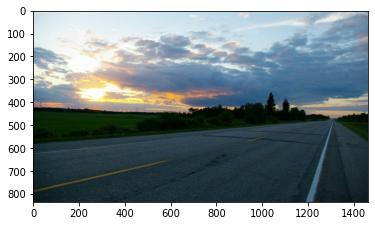

In [31]:
weather_list[np.argmax(make_predictions("../input/random/1.png"))],period_list[np.argmax(make_predictions2("../input/random/1.png"))]

('Sunny', 'Dusk')

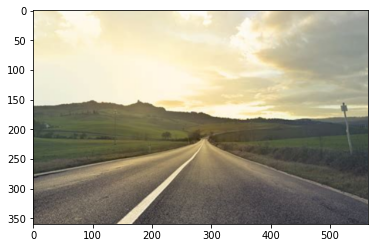

In [33]:
weather_list[np.argmax(make_predictions("../input/random/3.png"))],period_list[np.argmax(make_predictions2("../input/random/3.png"))]

('Sunny', 'Dusk')

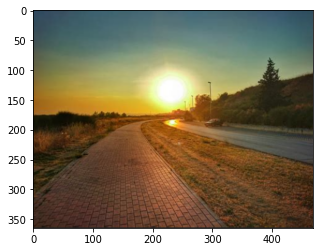

In [36]:
weather_list[np.argmax(make_predictions("../input/random/6.png"))],period_list[np.argmax(make_predictions2("../input/random/6.png"))]